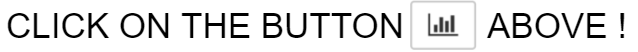

In [ ]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%reload_ext nb_black


<div align="center">

# EDS-TeVa DEMO


<img src="https://aphp.github.io/edsteva/latest/assets/logo/edsteva_logo_demo.svg" alt="EDS-TeVa">

</div>

EDS-TeVa can generate synthetic data that mimics OMOP data structure and the behavior of real hospital data. It is here to help you to test the different functionalities. It can also helps to test your custom [probe](https://aphp.github.io/edsteva/latest/components/probe/) and custom [model](https://aphp.github.io/edsteva/latest/components/model/).


## I. Load the synthetic data

In [ ]:
from edsteva.io import SyntheticData
from datetime import datetime

data = SyntheticData(
    mean_visit=1000,  # Average number of visit per hospital
    t_min=datetime(2012, 1, 1),  # Minimum date of a record
    t_max=datetime(2022, 1, 1),  # Maximum date of a record
    seed=None,  # If int, it set a seed for random number generator
    mode="step",  # It "rect", it will generate data with rectangle like deployment
).generate()

In [ ]:
print(data.available_tables)  # See available tables
data.visit_detail.head()

## II. Administrative records modeling

### II.1 Aggregate data to compute the completeness predictor $c_{adm}(t)$

EDS-TeVa provides a python class [``VisitProbe``](https://aphp.github.io/edsteva/latest/reference/probes/visit/#edsteva.probes.visit.VisitProbe) that aggregates administrative data in order to obtain a completeness predictor for each care site and each stay type according to time:

$$
c_{adm}(t) = \frac{n_{adm}(t)}{n_{99}}
$$

For a given care site and a given stay type, $n_{adm}(t)$ is the number of administrative records per month $t$ and $n_{99}$ is the $99^{th}$ percentile of the $n_{adm}(t)$ distribution.

In [ ]:
from edsteva.probes import VisitProbe

visit = VisitProbe()
visit.compute(
    data,
    stay_types={
        "All": ".*",
        "Urg_Hospit": "urgence|hospitalisés",
        "Consult": "consultation",
    },
    care_site_levels=["Hospital", "Pole", "UF"],
)
visit.save()
visit.predictor.sample(frac=1).head()

### II.2 Filter your Probe (optional)

In this example, let us consider we are only interested about "Hôpital-1" and "Hôpital-2" over the period from 2014 to 2021. We consequently filter data before any further analysis.

In [ ]:
from edsteva.probes import VisitProbe

start_date, end_date = (
    "2014-01-01",
    "2021-01-01",
)  # This is the study period considered in the example.
care_site_short_name = ["Hôpital-1", "Hôpital-2"]

filtered_visit = VisitProbe()

# `filtered_visit.predictor` is a `Pandas.DataFrame`, you can use Pandas'API to filter date.
filtered_visit.load()
filtered_visit.predictor = filtered_visit.predictor[
    (filtered_visit.predictor["date"] >= start_date)
    & (filtered_visit.predictor["date"] <= end_date)
]

# To filter care sites there is a dedicated method that also includes all upper and lower levels care sites related to the selected care sites.
filtered_visit.filter_care_site(care_site_short_names=care_site_short_name)

filtered_visit.predictor.sample(frac=1).head()

### II.2 Fit the Step Fucntion Model

The [``StepFunction``](https://aphp.github.io/edsteva/latest/reference/models/step_function/step_function/#edsteva.models.step_function.step_function.StepFunction) fits a step function $f_{t_0, c_0}(t)$ with coefficients $\Theta = (t_0, c_0)$ on a completeness predictor $c(t)$:

$$
\begin{aligned}
f_{t_0, c_0}(t) & = c_0 \ \mathbb{1}_{t \geq t_0}(t) \\
c(t) & = f_{t_0, c_0}(t) + \epsilon(t)
\end{aligned}
$$

- the characteristic time $t_0$ estimates the time after which the data is available.
- the characteristic value $c_0$ estimates the stabilized routine completeness.

In [ ]:
from edsteva.models.step_function import StepFunction

visit_model = StepFunction()
visit_model.fit(
    probe=filtered_visit,
)
visit_model.save()
visit_model.estimates.sample(frac=1).head()

## III. Visualize the model

EDS-TeVa library provides dashboards and plots to visualize the temporal evolution of [Probes](https://aphp.github.io/edsteva/latest/components/probe/) along with fitted [Models](https://aphp.github.io/edsteva/latest/components/model/). Visualization functionalities can be used to explore the database and set thresholds relative to selection criteria.

### III.1 Show interactive dashboard

A **Dashboard** is an interactive [Altair](https://altair-viz.github.io/) chart that lets you visualize variables aggregated by any combination of columns included in the [Probe](https://aphp.github.io/edsteva/latest/components/probe/). In the library, the dashboards are divided into two parts:

- On the top, there is the plot of the aggregated variable of interest.
- On the bottom, there are interactive filters to set. Only the selected data is aggregated to produce the plot on the top.

In [ ]:
from edsteva.viz.dashboards import predictor_dashboard

predictor_dashboard(
    probe=visit,
    fitted_model=visit_model,
    care_site_level="UF",
)

### III.2 Plot the model

This static plot can be exported in png or svg. As it is less interactive, you may specify the filters in the inputs of the functions as follow:

In [ ]:
from edsteva.viz.plots import plot_probe

plot_probe(
    probe=visit,
    fitted_model=visit_model,
    care_site_level="Hospital",
    stay_type="All",
)

## IV. Set the thresholds to fix the deployment bias

Now, that we have estimated $t_0$, $c_0$ and $error$ for each care site and each stay type, one can set a threshold for each estimate in order to select only the care sites where the visits are available over the period of interest.

### IV.1 Estimates distributions

Visualizing the density plots and the medians of the estimates can help you setting the thresholds' values.

In [ ]:
from edsteva.viz.plots import plot_estimates_densities

plot_estimates_densities(
    fitted_model=visit_model,
)

### IV.2 Estimates dashboard

The estimates dashboard provides a representation of the overall deviation from the Model on the top and interactive sliders on the bottom that allows you to vary the thresholds. The idea is to set the thresholds that keep the most care sites while having an acceptable overall deviation.

In [ ]:
from edsteva.viz.dashboards import estimates_dashboard

estimates_dashboard(
    probe=visit,
    fitted_model=visit_model,
    care_site_level="UF", # You can modify the level
)

### IV.2 Fix the deployment bias

In [ ]:
t_0_max = "2009-01-01"  # (1)
c_0_min = 0.63  # (2)
error_max = 0.03  # (3)

estimates = step_function_model.estimates
selected_care_site = estimates[
    (estimates["t_0"] <= t_0_max)
    & (estimates["c_0"] >= c_0_min)
    & (estimates["error"] <= error_max)
]
print(selected_care_site["care_site_id"].tolist())

In this example, $c_0$ and $error$ thresholds have been set around the median (cf. [distribution](#IV.1-Estimates-distributions)). However, this method is arbitrary and you have to find the appropriate method for your study with the help of the [estimate dashboard](#IV.1-Estimates-distributions).

## V. We need you to improve it

### V.1 Limitations

In this example, $c_0$ and $error$ thresholds have been set around the median (cf. [distribution](#IV.1-Estimates-distributions)). However, this method is arbitrary and you have to find the appropriate method for your study with the help of the [estimate dashboard](#IV.1-Estimates-distributions).

EDS-TeVa provides modelling tools to characterize the temporal variability of your data, it does not intend to provide direct methods to fix the deployment bias. As an open-source library, EDS-TeVa is also here to host a discussion in order to facilitate collective methodological convergence on flexible solutions. The default methods proposed in this example is intended to be reviewed and challenged by the user community.

### V.2 Make it your own

The working example above describes the canonical usage workflow. However, you would probably need different Probes, Models, Visualizations and methods to set the thresholds for your projects. The components already available in the library are listed in the [documentation](https://aphp.github.io/edsteva/latest/#available-components) but if it doesn't meet your requirements, you are encouraged to create your own.

### V.3 Contribute

If you managed to implement your own component, or even if you just thought about a new component do not hesitate to share it with the community by following the [contribution guidelines](https://aphp.github.io/edsteva/latest/contributing/). Contributions are welcome, and they are greatly appreciated! Every little bit helps, and credit will always be given.